In [3]:
import json
import os

import cv2
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
import torch
from torch.utils.data import Dataset, DataLoader 
import random 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

## Some utilities

In [7]:
# for mlt-gpu-2:
BASE = "/srv/data/lt2326-h25/lt2326-h25/a1"
# for mlt-gpu:
#BASE = "/srv/data/lt2326-h25/a1"
IMG_DIR = os.path.join(BASE, "images")
TRAIN_JSONL = os.path.join(BASE, "train.jsonl")

# Costants of the datasset
IMG_HEIGHT = 2048
IMG_WIDTH = 2048
IMG_CHANNELS = 3

# Function for reading json files
def read_jsonl(path):
    """Read a .jsonl (JSON Lines) file and return a list of JSON objects."""
    anns = []
    try:
        with open(path, "r") as f:
            for line in f:
                line = line.strip()
                if line:
                    anns.append(json.loads(line))
    except FileNotFoundError:
        print(f"WARNING: File not found: {path}")
    return anns


# Function to create the mask from the given polygon properties
def rasterize_polygon_mask(h, w, polygons):
    # Initialize an empty mask filled with zeros (background)
    mask = np.zeros((h, w), dtype=np.uint8)
    if not polygons:
        return mask
    
    # Convert each polygon into the format required by cv2.fillPoly:
    # - Convert to float32, then round to nearest int
    # - Cast to int32
    # - Reshape into shape (N, 1, 2) as expected by OpenCV
    pts = [np.round(np.array(p, dtype=np.float32)).astype(np.int32).reshape(-1, 1, 2) for p in polygons]

    # Fill the polygons on the mask with value 1 (foreground)
    cv2.fillPoly(
        mask,
        pts=pts,
        color=1  # Set the color for the region
    )
    return mask

## Dataset with initialization for every polygon of every chinese character

In [13]:
# Target Images size for shrinking
TARGET_IMG_HEIGHT = 1024
TARGET_IMG_WIDTH = 1024

class ImageMaskDataset(Dataset):
    """
    Dataset with lazy loading and integrated resizing.
    Loads a high-res image (e.g., 2048x2048), rasterizes polygon labels
    at the ORIGINAL resolution, then downsamples to the target size
    (defaults: 1024 x 1024).
    Returns (image_tensor, mask_tensor).
    """
    
    def __init__(self, metadata_list, target_h=TARGET_IMG_HEIGHT, target_w=TARGET_IMG_WIDTH):
        self.metadata = metadata_list
        self.TH = target_h
        self.TW = target_w
        self.IMG_CHANNELS = 3

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # ---- LOAD IMAGE AT ORIGINAL RESOLUTION ----
        anno = self.metadata[idx]

        # Read BGR image; raise if missing or unreadable
        img = cv2.imread(anno["file_path"], cv2.IMREAD_COLOR)
        if img is None:
             raise RuntimeError(f"Failed to read image: {anno['file_path']}")

        # Convert BGR to RGB and copy to ensure a contiguous array
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        chinese_polys, ignore_polys = [], []
        # Extract polygons marked as chinese (or default True)
        # Expected structure: anno["annotations"] is a list of textlines,
        # each textline is a list of instances (dicts)
        for textline in anno["annotations"]:
            for inst in textline:
                poly = inst.get("polygon")
                if poly and len(poly) >= 3 and inst.get("is_chinese", True):
                    chinese_polys.append(poly)

        # Polygons to ignore (will be subtracted from the final mask)
        for ign in anno["ignore"]:
            poly = ign.get("polygon")
            if poly and len(poly) >= 3:
                ignore_polys.append(poly)
                
        # ---- RASTERIZE MASKS AT ORIGINAL SIZE ----
        H_orig, W_orig = img.shape[:2]
        chinese_mask = rasterize_polygon_mask(H_orig, W_orig, chinese_polys)
        ignore_mask = rasterize_polygon_mask(H_orig, W_orig, ignore_polys)

        # Keep pixels that are chinese AND NOT ignored
        # final_mask is boolean; cast to uint8 {0,1}
        final_mask = (chinese_mask == 1) & (ignore_mask == 0)
        mask_orig = final_mask.astype(np.uint8) 
        
        # ---- RESIZE TO TARGET SIZE ----
        # Image: use AREA for high-quality downsampling
        if (H_orig, W_orig) != (self.TH, self.TW):
            image_resized = cv2.resize(img, (self.TW, self.TH), interpolation=cv2.INTER_AREA)
        else:
            image_resized = img

        # Mask: use NEAREST to preserve crisp class boundaries and small parts (interpolation)
        if (H_orig, W_orig) != (self.TH, self.TW):
            mask_resized = cv2.resize(mask_orig, (self.TW, self.TH), interpolation=cv2.INTER_NEAREST)
        else:
            mask_resized = mask_orig
            
        # ---- CONVERT TO PYTORCH TENSORS ----
        # Image: HWC to CHW, float32 in [0,1]
        image = image_resized[:, :, :self.IMG_CHANNELS]
        image = np.transpose(image, (2, 0, 1)) 
        image = image.astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image)
        
        # Mask: shape from (H, W) to (1, H, W), float32 in {0.0, 1.0}
        mask_tensor = torch.from_numpy(mask_resized[np.newaxis, :, :].astype(np.float32))
            
        return image_tensor, mask_tensor

## Conv block and weight initialization

In [9]:
# === Initialization function 'he_normal' ===
def weights_init(m):
    if isinstance(m, nn.Conv2d):
         # Apply Kaiming/He initialization to Conv2D weights.
        # In Keras, 'he_normal' corresponds to Kaiming initialization for ReLU activations.
        # Here we use 'kaiming_uniform_' as the closest match (uniform instead of normal).
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

        # Initialize biases to 0 (if present).
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
    elif isinstance(m, nn.ConvTranspose2d):
        # Same initialization strategy for ConvTranspose2d (used in decoders/upsampling).
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# === Convolutional block for Encoder and Decoder ===
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate):
        super(ConvBlock, self).__init__()
        
        # Sequential container of layers (executed in order).
        self.conv_seq = nn.Sequential(
             # Conv 1: 3x3 kernel, padding=1 to keep same H/W size, followed by ReLU
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv 2: another 3x3 + ReLU
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            #  Dropout for regularization (spatial dropout: drops entire channels at once)
            nn.Dropout2d(dropout_rate),
            
            # Conv 3: another 3x3 + ReLU
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Pass input through the sequence of conv + activation + dropout layers
        return self.conv_seq(x)

## U-NET

In [8]:
class CustomUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CustomUNet, self).__init__()
        
        # ENCODER: feature extraction with downsampling via MaxPool
        # Block 1: 3 -> 16
        self.c1 = ConvBlock(in_channels, 16, 0.1)
        self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Block 2: 16 -> 32
        self.c2 = ConvBlock(16, 32, 0.1)
        self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Block 3: 32 -> 64
        self.c3 = ConvBlock(32, 64, 0.2) # Dropout 0.2
        self.p3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Block 4: 64 -> 128
        self.c4 = ConvBlock(64, 128, 0.2) # Dropout 0.2
        self.p4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Block 5: 128 -> 256
        self.c5 = ConvBlock(128, 256, 0.3) # Dropout 0.3
        self.p5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # BOTTLENECK: deepest features (no further pooling)
        # Block 6: 256 -> 512
        self.c6 = ConvBlock(256, 512, 0.3) # Dropout 0.3


        # DECODER: upsample (transpose conv), concat skip, refine with ConvBlock
        # Block 7 (Back 1): 512 -> 256
        self.u7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.c7 = ConvBlock(512, 256, 0.3) # 512 = 256 (UpConv) + 256 (c5 Skip)
        # Block 8 (Back 2): 256 -> 128
        self.u8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.c8 = ConvBlock(256, 128, 0.2) # 256 = 128 (UpConv) + 128 (c4 Skip)
        # Block 9 (Back 3): 128 -> 64
        self.u9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.c9 = ConvBlock(128, 64, 0.2) # 128 = 64 (UpConv) + 64 (c3 Skip)
        # Block 10 (Back 4): 64 -> 32
        self.u10 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.c10 = ConvBlock(64, 32, 0.1) # 64 = 32 (UpConv) + 32 (c2 Skip)
        # Block 11 (Back 5): 32 -> 16
        self.u11 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.c11 = ConvBlock(32, 16, 0.1) # 32 = 16 (UpConv) + 16 (c1 Skip)

        # 1×1 convolution to map features to desired output channels (e.g., 1 for binary mask)
        self.outputs = nn.Conv2d(16, out_channels, kernel_size=1)
        
        # Apply He/Kaiming initialization to conv / deconv layers
        self.apply(weights_init)


    def forward(self, x):
        # x: (N, C, H, W)
        # ENCODER (save outputs for skip connections)
        c1 = self.c1(x) # c1 (skip)
        p1 = self.p1(c1)
        c2 = self.c2(p1) # c2 (skip)
        p2 = self.p2(c2)
        c3 = self.c3(p2) # c3 (skip)
        p3 = self.p3(c3)
        c4 = self.c4(p3) # c4 (skip)
        p4 = self.p4(c4)
        c5 = self.c5(p4) # c5 (skip)
        p5 = self.p5(c5)
        
        # BOTTLENECK
        c6 = self.c6(p5) 
        
        # DECODER: upsample -> concat skip -> conv block
        u7 = self.u7(c6)
        u7 = torch.cat([u7, c5], dim=1) 
        c7 = self.c7(u7)
        # Block 8 (Back 2): UpConv + c4
        u8 = self.u8(c7)
        u8 = torch.cat([u8, c4], dim=1) 
        c8 = self.c8(u8)
        # Block 9 (Back 3): UpConv + c3
        u9 = self.u9(c8)
        u9 = torch.cat([u9, c3], dim=1) 
        c9 = self.c9(u9)
        # Block 10 (Back 4): UpConv + c2
        u10 = self.u10(c9)
        u10 = torch.cat([u10, c2], dim=1)
        c10 = self.c10(u10)
        # Block 11 (Back 5): UpConv + c1
        u11 = self.u11(c10)
        u11 = torch.cat([u11, c1], dim=1)
        c11 = self.c11(u11)
        
        # OUTPUT
        # Produce logits and squash with sigmoid for probabilities in [0,1]
        # Last conv layer (kernel 1x1, 1 canale di output)
        logits = self.outputs(c11)
        output = torch.sigmoid(logits) 
        return output

    def extract_features(self, x):
        """Extract compressed features from the bottleneck for the classification task of Bonus A"""
        # ENCODER
        c1 = self.c1(x) 
        p1 = self.p1(c1)
        
        c2 = self.c2(p1) 
        p2 = self.p2(c2)
        
        c3 = self.c3(p2) 
        p3 = self.p3(c3)
        
        c4 = self.c4(p3) 
        p4 = self.p4(c4)
        
        c5 = self.c5(p4) 
        p5 = self.p5(c5)
        
        # Bottleneck
        c6 = self.c6(p5) # Output compressed features (N, 512, H/32, W/32)
        return c6

In [17]:
# Creation of the model
model = CustomUNet(in_channels=3, out_channels=1)

# Definition for the usage of the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print of the structure
print(model)

CustomUNet(
  (c1): ConvBlock(
    (conv_seq): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): ConvBlock(
    (conv_seq): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
  )
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Model visualization

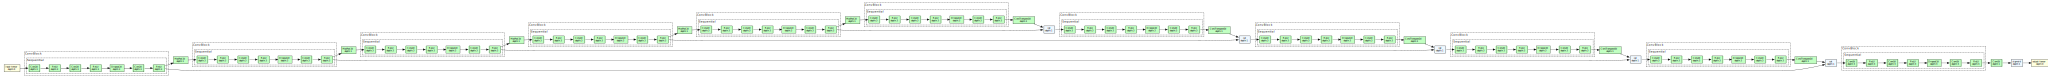

In [7]:
from torchview import draw_graph
# Code to visualize the model from https://github.com/mert-kurttutan/torchview

#model.eval()

batch_size = 8
C = 3  
H = TARGET_IMG_HEIGHT 
W = TARGET_IMG_WIDTH

model_graph = draw_graph(
    model,
    input_size=(batch_size, C, H, W), 
    device=torch.device('cuda'),
    expand_nested=True,
    show_shapes=False,
    graph_dir = "LR",
    save_graph = True,
)
model_graph.visual_graph

# Back to training mode
#model.train()

## Initialization of Intersection over Union metric and Dice Loss function

In [8]:
def iou_coef_pytorch(y_true, y_pred, smooth=1.0):
    """
    Computes the IoU (Intersection over Union) coefficient for PyTorch.
    
    Args:
        y_true: Ground truth tensor (usually shaped [Batch, 1, H, W]) with float values in [0, 1].
        y_pred: Predicted tensor (same shape as y_true) with float values in [0, 1].
        smooth: Small constant to avoid division by zero.
    """
    
    # Flatten both tensors and ensure they are float
    y_true = y_true.view(-1).float()
    y_pred = y_pred.view(-1).float()
    
    # Compute Intersection and Union
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    
    # Return IoU coefficient with smoothing
    # Smoothing prevents division by zero when both y_true and y_pred are empty
    return (intersection + smooth) / (union + smooth)

# Loss Function: Dice Loss
class DiceLoss(nn.Module):
    """ Dice Loss is more sensitive to small regions, as the ones in our case """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Flatten tensors: (B, C, H, W) to (B*C*H*W)
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        # Compute intersection and Dice coefficient
        intersection = (y_pred * y_true).sum()
        dice_coefficient = (2. * intersection + self.smooth) / \
                           (y_pred.sum() + y_true.sum() + self.smooth)
        
        # Dice Loss = 1 - Dice Coefficient (to minimize instead of maximize)
        return 1.0 - dice_coefficient

### Setup hyperparams

In [9]:
# Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4  # Tipical Value

# Configuration
# Replace the standard BCE loss with Dice Loss
# loss_fn = nn.BCELoss()
loss_fn = DiceLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Device used for training: {device}")

Device used for training: cuda


## DATASET Setup

In [14]:
def load_split_metadata(jsonl_path, img_dir):
    """
    Load annotations from a JSONL file and check if the corresponding image 
    files exist (as we are using a small part of the whole dataset).
    Returns a list of metadata dictionaries instead of full NumPy arrays.
    """
       
    annos = read_jsonl(jsonl_path)
    if not os.path.isdir(img_dir):
        print(f"WARNING: Image directory not found: {img_dir}.")
        return []

    metadata_list = []
    
    # Build a metadata list with valid image paths and annotations
    for anno in annos:
        fname = anno.get("file_name")
        if fname and os.path.exists(os.path.join(img_dir, fname)):
            metadata_list.append({
                "file_path": os.path.join(img_dir, fname),
                "annotations": anno.get("annotations", []),
                "ignore": anno.get("ignore", [])
            })
            
    print(f"Loading of {os.path.basename(jsonl_path)}: Found {len(metadata_list)} valid images.")
    return metadata_list
    
# These lines create the missing variables by loading metadata
train_metadata = load_split_metadata(TRAIN_JSONL, IMG_DIR)
val_metadata = load_split_metadata(os.path.join(BASE, "val.jsonl"), IMG_DIR)

print("Train metadata loaded:", len(train_metadata))
print("Validation metadata loaded:", len(val_metadata))

NameError: name 'TRAIN_JSONL' is not defined

## Dataloader of trainin and validation

In [11]:
# Usage of Dataset and Dataloader (with TARGET_IMG_HEIGHT/WIDTH)
train_dataset = ImageMaskDataset(train_metadata, target_h=TARGET_IMG_HEIGHT, target_w=TARGET_IMG_WIDTH)
val_dataset = ImageMaskDataset(val_metadata, target_h=TARGET_IMG_HEIGHT, target_w=TARGET_IMG_WIDTH)

# Increase number of workers for loading the data faster
NUM_WORKERS = os.cpu_count() // 2
if NUM_WORKERS == 0: NUM_WORKERS = 1 # at least 1

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

## Image with mask example

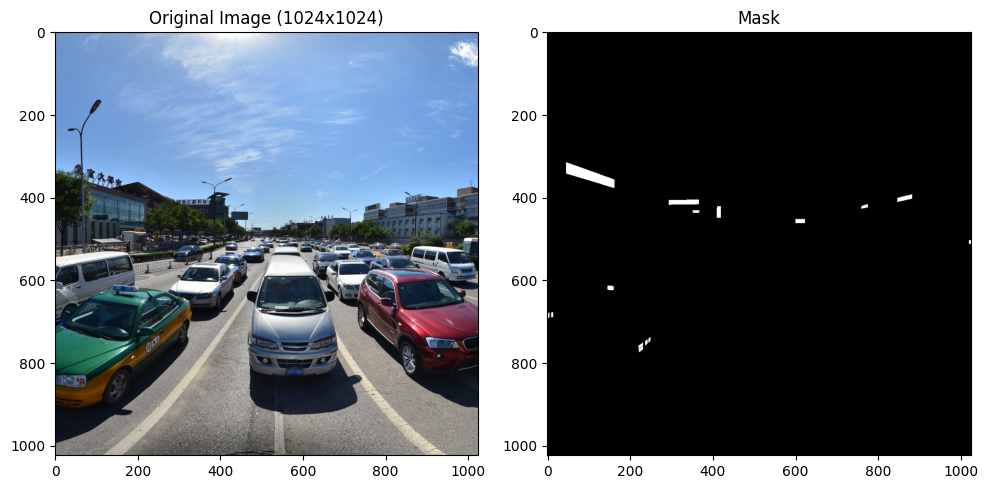

In [12]:
# Get a random item
# The function __getitem__ gives a PyTorch tensor (C, H, W)
image_random_idx = random.randint(0, len(train_dataset) - 1) 
image_tensor, mask_tensor = train_dataset[image_random_idx]

# From PyTorch (C, H, W) to NumPy/Matplotlib (H, W, C)
image_np = image_tensor.numpy().transpose(1, 2, 0)

# Mask: (1, H, W) -> (H, W). Float [0, 1]
mask_np = mask_tensor.numpy().squeeze()
# mask_np = mask_np.astype(bool) 

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axs[0].imshow(image_np)
axs[0].set_title(f'Original Image ({image_np.shape[0]}x{image_np.shape[1]})')
axs[0].axis('on')

# Mask
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('on')

plt.tight_layout()
plt.show()

## TRAINING

In [13]:
# Metric containers
train_losses = []
val_losses = []
val_iou = []

best_iou = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    
    # TRAINING PHASE
    model.train() # Enable training mode (activates Dropout, etc...)
    total_train_loss = 0.0
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} (Train)")):
        
        # Move inputs/targets to device
        data, targets = data.to(device), targets.to(device)

        # 1) Forward pass
        predictions = model(data)
        
        # 2) Compute loss
        # Targets shape must match predictions shape
        loss = loss_fn(predictions, targets)
        
        # 3) Backpropagation and optimizer step
        optimizer.zero_grad() # reset accumulated grads
        loss.backward()       # compute parameter gradients
        optimizer.step()      # update parameters (weights)

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDATION PHASE
    model.eval() # Evaluation mode (disables Dropout, etc...)
    total_val_loss = 0.0
    total_val_iou = 0.0
    
    with torch.no_grad(): # no gradient tracking and computation in validation
        for data, targets in tqdm(val_loader, desc="           (Val)"):
            data, targets = data.to(device), targets.to(device)
            
            predictions = model(data)
            
            # Loss on validation batch
            loss = loss_fn(predictions, targets)
            total_val_loss += loss.item()
            
            # IoU metric:
            # Use a binarized prediction for final IoU (threshold 0.5).
            iou = iou_coef_pytorch(targets, (predictions > 0.5).float())
            total_val_iou += iou.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_iou = total_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_iou.append(avg_val_iou)
    
    end_time = time.time()
    
    # Log epoch summary (Keras-style)
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} - {int(end_time - start_time)}s/epoch - train_iou:  - loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f} - val_iou: {avg_val_iou:.4f}")
    
    # CHECKPOINTING: save best model by val IoU
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model, 'best_unet_model.pth')
        print("SAVED!")

           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]



Epoch 1/100 - 50s/epoch - train_iou:  - loss: 0.9881 - val_loss: 0.9736 - val_iou: 0.0171
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]



Epoch 2/100 - 49s/epoch - train_iou:  - loss: 0.9589 - val_loss: 0.8895 - val_iou: 0.0600
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]



Epoch 3/100 - 48s/epoch - train_iou:  - loss: 0.8984 - val_loss: 0.8591 - val_iou: 0.0781
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]



Epoch 4/100 - 48s/epoch - train_iou:  - loss: 0.8866 - val_loss: 0.8622 - val_iou: 0.0760


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.62it/s]



Epoch 5/100 - 49s/epoch - train_iou:  - loss: 0.8516 - val_loss: 0.7925 - val_iou: 0.1186
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]



Epoch 6/100 - 48s/epoch - train_iou:  - loss: 0.8168 - val_loss: 0.7624 - val_iou: 0.1396
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]



Epoch 7/100 - 48s/epoch - train_iou:  - loss: 0.7911 - val_loss: 0.7533 - val_iou: 0.1456
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]



Epoch 8/100 - 48s/epoch - train_iou:  - loss: 0.7625 - val_loss: 0.7387 - val_iou: 0.1556
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]



Epoch 9/100 - 48s/epoch - train_iou:  - loss: 0.7261 - val_loss: 0.6876 - val_iou: 0.1924
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.38it/s]



Epoch 10/100 - 49s/epoch - train_iou:  - loss: 0.7175 - val_loss: 0.6872 - val_iou: 0.1921


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.58it/s]



Epoch 11/100 - 48s/epoch - train_iou:  - loss: 0.7026 - val_loss: 0.6684 - val_iou: 0.2067
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]



Epoch 12/100 - 48s/epoch - train_iou:  - loss: 0.6781 - val_loss: 0.6584 - val_iou: 0.2137
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]



Epoch 13/100 - 48s/epoch - train_iou:  - loss: 0.6715 - val_loss: 0.6921 - val_iou: 0.1875


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.89it/s]



Epoch 14/100 - 48s/epoch - train_iou:  - loss: 0.6537 - val_loss: 0.6421 - val_iou: 0.2256
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]



Epoch 15/100 - 49s/epoch - train_iou:  - loss: 0.6502 - val_loss: 0.6446 - val_iou: 0.2235


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.87it/s]



Epoch 16/100 - 48s/epoch - train_iou:  - loss: 0.6362 - val_loss: 0.7030 - val_iou: 0.1805


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.09it/s]



Epoch 17/100 - 48s/epoch - train_iou:  - loss: 0.6462 - val_loss: 0.6370 - val_iou: 0.2282
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.44it/s]



Epoch 18/100 - 48s/epoch - train_iou:  - loss: 0.6244 - val_loss: 0.6192 - val_iou: 0.2420
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.02it/s]



Epoch 19/100 - 48s/epoch - train_iou:  - loss: 0.6273 - val_loss: 0.6378 - val_iou: 0.2279


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.51it/s]



Epoch 20/100 - 48s/epoch - train_iou:  - loss: 0.6161 - val_loss: 0.6108 - val_iou: 0.2484
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.65it/s]



Epoch 21/100 - 49s/epoch - train_iou:  - loss: 0.5968 - val_loss: 0.5986 - val_iou: 0.2575
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.61it/s]



Epoch 22/100 - 49s/epoch - train_iou:  - loss: 0.5922 - val_loss: 0.6066 - val_iou: 0.2510


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]



Epoch 23/100 - 49s/epoch - train_iou:  - loss: 0.5899 - val_loss: 0.5976 - val_iou: 0.2584
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.51it/s]



Epoch 24/100 - 49s/epoch - train_iou:  - loss: 0.5844 - val_loss: 0.5843 - val_iou: 0.2700
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]



Epoch 25/100 - 48s/epoch - train_iou:  - loss: 0.5768 - val_loss: 0.5855 - val_iou: 0.2692


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]



Epoch 26/100 - 48s/epoch - train_iou:  - loss: 0.5654 - val_loss: 0.5736 - val_iou: 0.2777
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]



Epoch 27/100 - 48s/epoch - train_iou:  - loss: 0.5617 - val_loss: 0.5826 - val_iou: 0.2711


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]



Epoch 28/100 - 48s/epoch - train_iou:  - loss: 0.5551 - val_loss: 0.5749 - val_iou: 0.2775


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.98it/s]



Epoch 29/100 - 48s/epoch - train_iou:  - loss: 0.5591 - val_loss: 0.5972 - val_iou: 0.2587


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]



Epoch 30/100 - 49s/epoch - train_iou:  - loss: 0.5489 - val_loss: 0.5730 - val_iou: 0.2789
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]



Epoch 31/100 - 49s/epoch - train_iou:  - loss: 0.5352 - val_loss: 0.5489 - val_iou: 0.2983
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]



Epoch 32/100 - 49s/epoch - train_iou:  - loss: 0.5458 - val_loss: 0.5471 - val_iou: 0.2994
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.89it/s]



Epoch 33/100 - 48s/epoch - train_iou:  - loss: 0.5418 - val_loss: 0.5515 - val_iou: 0.2967


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.00it/s]



Epoch 34/100 - 48s/epoch - train_iou:  - loss: 0.5288 - val_loss: 0.5461 - val_iou: 0.3007
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.37it/s]



Epoch 35/100 - 49s/epoch - train_iou:  - loss: 0.5361 - val_loss: 0.5441 - val_iou: 0.3032
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]



Epoch 36/100 - 48s/epoch - train_iou:  - loss: 0.5257 - val_loss: 0.5355 - val_iou: 0.3107
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.51it/s]



Epoch 37/100 - 48s/epoch - train_iou:  - loss: 0.5157 - val_loss: 0.5701 - val_iou: 0.2802


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.66it/s]



Epoch 38/100 - 48s/epoch - train_iou:  - loss: 0.5106 - val_loss: 0.5343 - val_iou: 0.3114
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]



Epoch 39/100 - 49s/epoch - train_iou:  - loss: 0.4950 - val_loss: 0.5347 - val_iou: 0.3117
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  5.00it/s]



Epoch 40/100 - 48s/epoch - train_iou:  - loss: 0.5042 - val_loss: 0.5234 - val_iou: 0.3216
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.86it/s]



Epoch 41/100 - 48s/epoch - train_iou:  - loss: 0.4922 - val_loss: 0.5265 - val_iou: 0.3184


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]



Epoch 42/100 - 49s/epoch - train_iou:  - loss: 0.4949 - val_loss: 0.5251 - val_iou: 0.3199


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]



Epoch 43/100 - 48s/epoch - train_iou:  - loss: 0.4977 - val_loss: 0.5263 - val_iou: 0.3183


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.50it/s]



Epoch 44/100 - 49s/epoch - train_iou:  - loss: 0.4783 - val_loss: 0.5210 - val_iou: 0.3233
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]



Epoch 45/100 - 49s/epoch - train_iou:  - loss: 0.4739 - val_loss: 0.5230 - val_iou: 0.3219


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]



Epoch 46/100 - 48s/epoch - train_iou:  - loss: 0.4759 - val_loss: 0.5249 - val_iou: 0.3213


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]



Epoch 47/100 - 49s/epoch - train_iou:  - loss: 0.4732 - val_loss: 0.5190 - val_iou: 0.3254
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]



Epoch 48/100 - 48s/epoch - train_iou:  - loss: 0.4741 - val_loss: 0.5288 - val_iou: 0.3161


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.49it/s]



Epoch 49/100 - 48s/epoch - train_iou:  - loss: 0.4679 - val_loss: 0.5159 - val_iou: 0.3278
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.36it/s]



Epoch 50/100 - 49s/epoch - train_iou:  - loss: 0.4596 - val_loss: 0.5108 - val_iou: 0.3328
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.55it/s]



Epoch 51/100 - 49s/epoch - train_iou:  - loss: 0.4676 - val_loss: 0.5106 - val_iou: 0.3322


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]



Epoch 52/100 - 49s/epoch - train_iou:  - loss: 0.4593 - val_loss: 0.5177 - val_iou: 0.3268


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]



Epoch 53/100 - 49s/epoch - train_iou:  - loss: 0.4617 - val_loss: 0.5066 - val_iou: 0.3365
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.52it/s]



Epoch 54/100 - 49s/epoch - train_iou:  - loss: 0.4530 - val_loss: 0.5031 - val_iou: 0.3398
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]



Epoch 55/100 - 48s/epoch - train_iou:  - loss: 0.4466 - val_loss: 0.5031 - val_iou: 0.3404
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]



Epoch 56/100 - 48s/epoch - train_iou:  - loss: 0.4449 - val_loss: 0.5074 - val_iou: 0.3360


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]



Epoch 57/100 - 48s/epoch - train_iou:  - loss: 0.4452 - val_loss: 0.4980 - val_iou: 0.3444
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.42it/s]



Epoch 58/100 - 49s/epoch - train_iou:  - loss: 0.4484 - val_loss: 0.5303 - val_iou: 0.3163


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.03it/s]



Epoch 59/100 - 49s/epoch - train_iou:  - loss: 0.4358 - val_loss: 0.5139 - val_iou: 0.3315


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]



Epoch 60/100 - 48s/epoch - train_iou:  - loss: 0.4376 - val_loss: 0.4999 - val_iou: 0.3425


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.92it/s]



Epoch 61/100 - 48s/epoch - train_iou:  - loss: 0.4260 - val_loss: 0.5050 - val_iou: 0.3391


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]



Epoch 62/100 - 48s/epoch - train_iou:  - loss: 0.4304 - val_loss: 0.4958 - val_iou: 0.3463
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.47it/s]



Epoch 63/100 - 49s/epoch - train_iou:  - loss: 0.4324 - val_loss: 0.4823 - val_iou: 0.3589
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]



Epoch 64/100 - 49s/epoch - train_iou:  - loss: 0.4200 - val_loss: 0.5080 - val_iou: 0.3375


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]



Epoch 65/100 - 48s/epoch - train_iou:  - loss: 0.4204 - val_loss: 0.4813 - val_iou: 0.3600
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]



Epoch 66/100 - 49s/epoch - train_iou:  - loss: 0.4170 - val_loss: 0.5005 - val_iou: 0.3416


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]



Epoch 67/100 - 48s/epoch - train_iou:  - loss: 0.4163 - val_loss: 0.4927 - val_iou: 0.3487


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.86it/s]



Epoch 68/100 - 48s/epoch - train_iou:  - loss: 0.4085 - val_loss: 0.4888 - val_iou: 0.3525


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]



Epoch 69/100 - 48s/epoch - train_iou:  - loss: 0.4117 - val_loss: 0.4940 - val_iou: 0.3490


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]



Epoch 70/100 - 48s/epoch - train_iou:  - loss: 0.4143 - val_loss: 0.4961 - val_iou: 0.3468


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.59it/s]



Epoch 71/100 - 48s/epoch - train_iou:  - loss: 0.3969 - val_loss: 0.5000 - val_iou: 0.3425


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]



Epoch 72/100 - 49s/epoch - train_iou:  - loss: 0.4036 - val_loss: 0.4870 - val_iou: 0.3546


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]



Epoch 73/100 - 48s/epoch - train_iou:  - loss: 0.3972 - val_loss: 0.4883 - val_iou: 0.3534


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]



Epoch 74/100 - 49s/epoch - train_iou:  - loss: 0.4102 - val_loss: 0.5030 - val_iou: 0.3404


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.50it/s]



Epoch 75/100 - 48s/epoch - train_iou:  - loss: 0.3968 - val_loss: 0.5070 - val_iou: 0.3360


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.93it/s]



Epoch 76/100 - 49s/epoch - train_iou:  - loss: 0.4085 - val_loss: 0.5088 - val_iou: 0.3355


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.33it/s]



Epoch 77/100 - 49s/epoch - train_iou:  - loss: 0.3935 - val_loss: 0.4856 - val_iou: 0.3557


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]



Epoch 78/100 - 48s/epoch - train_iou:  - loss: 0.3832 - val_loss: 0.4798 - val_iou: 0.3611
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]



Epoch 79/100 - 49s/epoch - train_iou:  - loss: 0.3844 - val_loss: 0.4759 - val_iou: 0.3641
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.61it/s]



Epoch 80/100 - 49s/epoch - train_iou:  - loss: 0.3836 - val_loss: 0.4839 - val_iou: 0.3579


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.58it/s]



Epoch 81/100 - 48s/epoch - train_iou:  - loss: 0.3850 - val_loss: 0.4864 - val_iou: 0.3551


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]



Epoch 82/100 - 49s/epoch - train_iou:  - loss: 0.3745 - val_loss: 0.4832 - val_iou: 0.3582


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.65it/s]



Epoch 83/100 - 48s/epoch - train_iou:  - loss: 0.3887 - val_loss: 0.4993 - val_iou: 0.3434


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]



Epoch 84/100 - 49s/epoch - train_iou:  - loss: 0.3845 - val_loss: 0.4803 - val_iou: 0.3610


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]



Epoch 85/100 - 48s/epoch - train_iou:  - loss: 0.3845 - val_loss: 0.5000 - val_iou: 0.3425


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.39it/s]



Epoch 86/100 - 49s/epoch - train_iou:  - loss: 0.3771 - val_loss: 0.4889 - val_iou: 0.3523


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]



Epoch 87/100 - 48s/epoch - train_iou:  - loss: 0.3734 - val_loss: 0.4817 - val_iou: 0.3591


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.47it/s]



Epoch 88/100 - 48s/epoch - train_iou:  - loss: 0.3681 - val_loss: 0.4948 - val_iou: 0.3471


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.88it/s]



Epoch 89/100 - 49s/epoch - train_iou:  - loss: 0.3628 - val_loss: 0.4790 - val_iou: 0.3630


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.93it/s]



Epoch 90/100 - 48s/epoch - train_iou:  - loss: 0.3683 - val_loss: 0.4852 - val_iou: 0.3569


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.55it/s]



Epoch 91/100 - 49s/epoch - train_iou:  - loss: 0.3545 - val_loss: 0.4813 - val_iou: 0.3605


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.09it/s]



Epoch 92/100 - 49s/epoch - train_iou:  - loss: 0.3544 - val_loss: 0.4761 - val_iou: 0.3661
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.86it/s]



Epoch 93/100 - 48s/epoch - train_iou:  - loss: 0.3591 - val_loss: 0.4858 - val_iou: 0.3567


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.16it/s]



Epoch 94/100 - 48s/epoch - train_iou:  - loss: 0.3586 - val_loss: 0.4780 - val_iou: 0.3631


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.60it/s]



Epoch 95/100 - 48s/epoch - train_iou:  - loss: 0.3490 - val_loss: 0.4667 - val_iou: 0.3729
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.60it/s]



Epoch 96/100 - 49s/epoch - train_iou:  - loss: 0.3546 - val_loss: 0.4844 - val_iou: 0.3576


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.66it/s]



Epoch 97/100 - 48s/epoch - train_iou:  - loss: 0.3436 - val_loss: 0.4873 - val_iou: 0.3549


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]



Epoch 98/100 - 48s/epoch - train_iou:  - loss: 0.3405 - val_loss: 0.4858 - val_iou: 0.3567


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.64it/s]



Epoch 99/100 - 49s/epoch - train_iou:  - loss: 0.3442 - val_loss: 0.4779 - val_iou: 0.3637


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 100/100 - 48s/epoch - train_iou:  - loss: 0.3479 - val_loss: 0.4738 - val_iou: 0.3672


## Visual test with loading of the model

In [15]:
MODEL_PATH = 'best_unet_model.pth'

try:
    unet_model = CustomUNet(in_channels=3, out_channels=1) 
except NameError:
    print("ERROR: you have to execute the block of the definition of CustomUNet")
    raise

# Weights load
unet_model=torch.load(MODEL_PATH, map_location=device, weights_only=False)

unet_model.to(device)
unet_model.eval() 

CustomUNet(
  (c1): ConvBlock(
    (conv_seq): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): ConvBlock(
    (conv_seq): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
  )
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Random image example with mask overlay

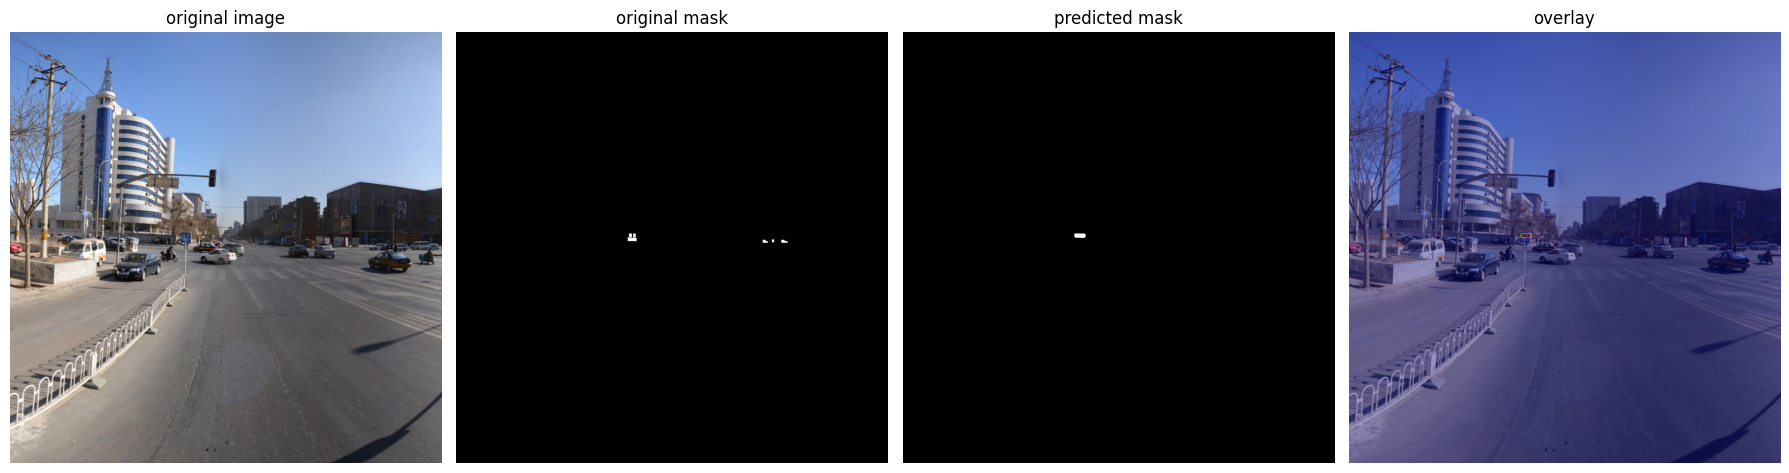

In [16]:
# Pick a random index from the validation set
ind = random.randint(0, len(val_dataset) - 1)

# Extract an item from the dataset (returns tensors: C, H, W)
img_tensor, gt_tensor = val_dataset[ind] 

# Move tensor to device (GPU/CPU) for prediction
# PyTorch expects a batch, so we add a batch dimension: (1, C, H, W)
img_batch = img_tensor.unsqueeze(0).to(device)

# Model Prediction (Manual Forward Pass)
unet_model.eval() # Evaluation mode (disables dropout, etc.)
with torch.no_grad():
    pred_tensor = unet_model(img_batch) 

# Convert tensors to NumPy for Matplotlib visualization
# Original image: (C, H, W) -> (H, W, C)
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

# Ground Truth: (1, H, W) -> (H, W) float in [0, 1]
gt_vis = gt_tensor.cpu().numpy().squeeze() 

# Prediction
pred_vis = pred_tensor.cpu().numpy().squeeze() 

# Plot
plt.figure(figsize=(18, 5))

# Subplot 1: Original Image
plt.subplot(1, 4, 1)
plt.title("original image")
plt.axis('off')
plt.imshow(img_np) # Already normalized [0, 1]

# Subplot 2: Ground Truth Mask
plt.subplot(1, 4, 2)
plt.title("original mask")
plt.axis('off')
plt.imshow(gt_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 3: Predicted Mask (Soft Prediction)
plt.subplot(1, 4, 3)
plt.title("predicted mask")
plt.axis('off')
plt.imshow(pred_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 4: Overlay (Image + Predicted Mask)
plt.subplot(1, 4, 4)
plt.title("overlay")
plt.axis('off')
plt.imshow(img_np)
# Overlay prediction with a colormap and transparency
plt.imshow(pred_vis, cmap='jet', alpha=0.4, vmin=0, vmax=1)

plt.savefig("unet_ex.png")
plt.tight_layout()
plt.show()

# BONUS A

In [1]:
from collections import Counter
from torch import optim
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.patches as patches

## Classifier structure

In [6]:
class FeatureClassifier(nn.Module):
    def __init__(self, unet_model):
        super(FeatureClassifier, self).__init__()
        
        # Frozen U-Netu sed purely as a feature extractor.
        self.unet_feature_extractor = unet_model
        
         # Freeze ALL parameters of the backbone so only the head learns.
        for param in self.unet_feature_extractor.parameters():
            param.requires_grad = False 
        
        # Number of channels produced by the backbone's feature map.
        FEATURE_CHANNELS = 512 
        
        # Classification head
        self.classifier_head = nn.Sequential(
            # Global Average Pooling: riduce (512, H/32, W/32) a (512, 1, 1)
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(),
            nn.Linear(FEATURE_CHANNELS, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1), # Output for Binary classification
            #nn.Sigmoid() # Sigmoid is intentionally omitted so we can train with BCEWithLogitsLoss.
        )

    def forward(self, x):
        # Extract deep features from the frozen U-Net backbone.
        x = self.unet_feature_extractor.extract_features(x)
        
        # Classification head to get a single logit per sample.
        x = self.classifier_head(x)
        return x

### Find the most common Chinese character

In [9]:
def find_most_common_character(jsonl_path):
    """
    Reads the training JSONL file and counts the frequency of each character.
    It ignores non-Chinese characters (is_chinese = False) and special symbols.
    """
    character_counts = Counter()   # Dictionary-like object to count character frequencies
    total_characters = 0           # Total valid characters found
    total_images = 0               # Total number of images (lines) processed

    try:
        # Open the JSONL file line by line
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                total_images += 1
                try:
                    data = json.loads(line.strip())
                    
                    # Iterate over all annotation lists
                    for annotation_list in data.get("annotations", []):
                        # Iterate over each single annotation in the list
                        for anno in annotation_list:
                            # Check if it's a Chinese character and has a 'text' field
                            if anno.get("is_chinese", False) and "text" in anno:
                                char = anno["text"].strip()
                                
                                if char and char != ' ' and char != '·': # Filter
                                    character_counts[char] += 1
                                    total_characters += 1
                                    
                except json.JSONDecodeError as e:
                    print(f"JSON decoding error in line: {e}")
                
    except FileNotFoundError:
        # Handle missing file error
        print(f"ERROR: File not found at {jsonl_path}")
        return None

    # If no valid characters were found
    if not character_counts:
        return None, 0, total_characters
        
    most_common = character_counts.most_common(1)[0]
    
    print(f"Analysis completed on {total_images} images.")
    print(f"Total valid Chinese characters found: {total_characters}")
    print("-" * 30)
    print(f"Top 5 characters:")
    for char, count in character_counts.most_common(5):
        print(f"  '{char}': {count} times ({count/total_characters*100:.2f}%)")
        
    return most_common[0], most_common[1], total_characters

most_common_char, count, total = find_most_common_character(TRAIN_JSONL) 

Analysis completed on 24290 images.
Total valid Chinese characters found: 760107
------------------------------
Top 5 characters:
  '中': 13042 times (1.72%)
  '国': 8831 times (1.16%)
  '大': 8261 times (1.09%)
  '电': 6448 times (0.85%)
  '车': 6164 times (0.81%)


## Dataset for the classification with the target character

In [10]:
class ClassificationDataset(Dataset):
    """
    Dataset for Bonus A: Binary classification (presence/absence of the target character).
    Reuses the logic for loading and resizing images.
    """
    def __init__(self, metadata_list, target_char, target_h=256, target_w=256):
        self.metadata = metadata_list
        self.TH = target_h # Target Height
        self.TW = target_w # Target Width
        self.IMG_CHANNELS = 3
        self.target_char = target_char # The specific character to detect

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        anno = self.metadata[idx]
        
        # IMAGE LOADING AND RESIZING
        img = cv2.imread(anno["file_path"], cv2.IMREAD_COLOR)
        if img is None:
             raise RuntimeError(f"Failed to read image: {anno['file_path']}")

        # Convert BGR (OpenCV default) to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H_orig, W_orig = img.shape[:2]
        
        # Resize the image 
        if (H_orig, W_orig) != (self.TH, self.TW):
            image_resized = cv2.resize(img, (self.TW, self.TH), interpolation=cv2.INTER_AREA)
        else:
            image_resized = img

        # Convert to PyTorch tensor and normalize
        image = image_resized[:, :, :self.IMG_CHANNELS]
        image = np.transpose(image, (2, 0, 1)) 
        image = image.astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image)
        
         # BINARY LABEL GENERATION
        is_present = 0 # Default: 0 = Absent
        
        # Iterate through annotations to check if the target character is present
        for textline in anno.get("annotations", []):
            for inst in textline: 
                char_text = inst.get('text', '').strip()
                
                if char_text == self.target_char:
                    is_present = 1 # 1: Present
                    break 
            if is_present == 1:
                break
        
        # Create the label as a single float tensor (required by BCELoss for binary classification)
        label = torch.tensor([float(is_present)]) 
            
        return image_tensor, label

In [18]:
# Initialize the U-Net model
model = CustomUNet(in_channels=3, out_channels=1) 

# Load model
model = torch.load('best_unet_model.pth', map_location='cpu', weights_only=False)

# Pass the U-Net model to the FeatureClassifier
classifier_model = FeatureClassifier(model) 

# Move the entire structure (including the U-Net features) to the device (GPU or CPU)
classifier_model = classifier_model.to(device)

## Parameters Configuration for classification

In [12]:
MOST_COMMON_CHAR = most_common_char 
BATCH_SIZE = 8 
TARGET_IMG_SIZE = 1024 
NUM_CLF_EPOCHS = 10

# Datasets and DataLoaders
train_clf_dataset = ClassificationDataset(train_metadata, target_char=MOST_COMMON_CHAR, 
                                        target_h=TARGET_IMG_SIZE, target_w=TARGET_IMG_SIZE)
val_clf_dataset = ClassificationDataset(val_metadata, target_char=MOST_COMMON_CHAR,
                                        target_h=TARGET_IMG_SIZE, target_w=TARGET_IMG_SIZE)

train_clf_loader = DataLoader(train_clf_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_clf_loader = DataLoader(val_clf_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, Loss, and Optimizer
classifier_model = FeatureClassifier(model).to(device)

# Optimize ONLY the unfrozen layers (the classifier_head)
optimizer_clf = optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=1e-3)
#loss_fn_clf = nn.BCELoss()

NameError: name 'most_common_char' is not defined

### Code created to balance the positive and negative samples

In [22]:
# Count positives and negatives in the training dataset
num_positives = sum([1 for _, label in train_clf_dataset if label.item() == 1.0])
num_negatives = len(train_clf_dataset) - num_positives

# Compute class weight
# pos_weight = (#negatives / #positives)
if num_positives == 0:
    print("No positive samples found in the training dataset. Impossible training.")
    POS_WEIGHT = torch.tensor([1.0], device=device)
else:
    POS_WEIGHT = torch.tensor([num_negatives / num_positives], device=device)

print(f"Positive samples: {num_positives}, Negative samples: {num_negatives}")
print(f"Weight for positives (pos_weight): {POS_WEIGHT.item():.2f}")

Positive samples: 353, Negative samples: 492
Weight for positives (pos_weight): 1.39


In [23]:
# Removed the sigmoid from the model to add this loss
loss_fn_clf = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT) 

## Training

In [25]:
NUM_CLF_EPOCHS = 100 # Se necessario, aumenta
best_f1_score = -1.0 
CHECKPOINT_FILENAME = 'best_classifier_weights.pth' 

for epoch in range(1, NUM_CLF_EPOCHS + 1):
    start_time = time.time()
    
    # TRAINING PHASE
    classifier_model.train() # Enable dropout, etc., for the head
    total_train_loss = 0.0
    
    for data, labels in tqdm(train_clf_loader, desc=f"Epoch {epoch}/{NUM_CLF_EPOCHS} (Train Clf)"):
        data, labels = data.to(device), labels.to(device)
        
        optimizer_clf.zero_grad()
        
        # Forward pass: outputs RAW LOGITS (not probabilities)
        predictions = classifier_model(data) # Output (N, 1) float
        
        # Compute loss directly on logits (more stable than applying Sigmoid first)
        loss = loss_fn_clf(predictions, labels)

        # Backprop + update
        loss.backward()
        optimizer_clf.step()
        
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_clf_loader)

    # VALIDATION PHASE
    classifier_model.eval()
    all_targets = []
    all_predictions = []
    total_val_loss = 0.0
    
    with torch.no_grad():
        for data, labels in tqdm(val_clf_loader, desc="           (Val Clf)"):
            data, labels = data.to(device), labels.to(device)

            # Forward: still logits
            predictions = classifier_model(data)
            # Validation loss on logits
            loss = loss_fn_clf(predictions, labels)
            total_val_loss += loss.item()
            
            # Convert logits into probabilities in [0,1]
            probabilities = torch.sigmoid(predictions) 
            
            # Binarize with a threshold (default 0.5)
            binary_preds = (probabilities > 0.5).float()
            
            # Move to CPU and flatten to 1D for sklearn
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(binary_preds.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_clf_loader)
    
    # METRICS
    targets_np = np.array(all_targets).flatten()
    preds_np = np.array(all_predictions).flatten()
    
    val_accuracy = accuracy_score(targets_np, preds_np)
    # F1 score used when there is unbalance between classes
    val_f1 = f1_score(targets_np, preds_np)
    
    end_time = time.time()
    
    # Logging
    print(f"\nEpoch {epoch}/{NUM_CLF_EPOCHS} - {int(end_time - start_time)}s/epoch")
    print(f"Loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_accuracy:.4f} - val_f1: {val_f1:.4f}")

    # CHECKPOINTING (save the best by F1) 
    if val_f1 > best_f1_score:
        print(f"Improved F1 from {best_f1_score:.4f} to {val_f1:.4f}. Saving weights...")
        best_f1_score = val_f1
        # Save only the classifier model's weights (state_dict)
        torch.save(classifier_model, CHECKPOINT_FILENAME)

           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch 1/100 - 37s/epoch
Loss: 0.7904 - val_loss: 0.7400 - val_acc: 0.6774 - val_f1: 0.3750
Improved F1 from -1.0000 to 0.3750. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch 2/100 - 37s/epoch
Loss: 0.7925 - val_loss: 0.7374 - val_acc: 0.6903 - val_f1: 0.3684


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 3/100 - 37s/epoch
Loss: 0.7928 - val_loss: 0.7412 - val_acc: 0.6774 - val_f1: 0.3750


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch 4/100 - 37s/epoch
Loss: 0.7852 - val_loss: 0.7409 - val_acc: 0.6645 - val_f1: 0.3810
Improved F1 from 0.3750 to 0.3810. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]



Epoch 5/100 - 37s/epoch
Loss: 0.7924 - val_loss: 0.7398 - val_acc: 0.6774 - val_f1: 0.3750


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch 6/100 - 37s/epoch
Loss: 0.7896 - val_loss: 0.7550 - val_acc: 0.6387 - val_f1: 0.3913
Improved F1 from 0.3810 to 0.3913. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]



Epoch 7/100 - 37s/epoch
Loss: 0.7919 - val_loss: 0.7513 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch 8/100 - 37s/epoch
Loss: 0.7821 - val_loss: 0.7499 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch 9/100 - 37s/epoch
Loss: 0.7918 - val_loss: 0.7461 - val_acc: 0.6452 - val_f1: 0.3678


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch 10/100 - 37s/epoch
Loss: 0.7892 - val_loss: 0.7592 - val_acc: 0.6387 - val_f1: 0.4167
Improved F1 from 0.3913 to 0.4167. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 11/100 - 37s/epoch
Loss: 0.7873 - val_loss: 0.7465 - val_acc: 0.6452 - val_f1: 0.3678


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 12/100 - 36s/epoch
Loss: 0.7892 - val_loss: 0.7609 - val_acc: 0.6258 - val_f1: 0.4082


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch 13/100 - 37s/epoch
Loss: 0.7924 - val_loss: 0.7487 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 14/100 - 36s/epoch
Loss: 0.7866 - val_loss: 0.7493 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 15/100 - 37s/epoch
Loss: 0.7933 - val_loss: 0.7393 - val_acc: 0.6968 - val_f1: 0.3733


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]



Epoch 16/100 - 36s/epoch
Loss: 0.7902 - val_loss: 0.7379 - val_acc: 0.6839 - val_f1: 0.3636


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 17/100 - 36s/epoch
Loss: 0.7819 - val_loss: 0.7527 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]



Epoch 18/100 - 37s/epoch
Loss: 0.7906 - val_loss: 0.7537 - val_acc: 0.6452 - val_f1: 0.3820


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch 19/100 - 37s/epoch
Loss: 0.7897 - val_loss: 0.7452 - val_acc: 0.6516 - val_f1: 0.3721


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch 20/100 - 37s/epoch
Loss: 0.7888 - val_loss: 0.7326 - val_acc: 0.7161 - val_f1: 0.3714


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch 21/100 - 37s/epoch
Loss: 0.7910 - val_loss: 0.7472 - val_acc: 0.6452 - val_f1: 0.3678


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch 22/100 - 37s/epoch
Loss: 0.7826 - val_loss: 0.7473 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 23/100 - 37s/epoch
Loss: 0.7892 - val_loss: 0.7550 - val_acc: 0.6387 - val_f1: 0.3778


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]



Epoch 24/100 - 36s/epoch
Loss: 0.7880 - val_loss: 0.7537 - val_acc: 0.6452 - val_f1: 0.3820


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch 25/100 - 37s/epoch
Loss: 0.7856 - val_loss: 0.7470 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 26/100 - 37s/epoch
Loss: 0.7938 - val_loss: 0.7505 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 27/100 - 36s/epoch
Loss: 0.7923 - val_loss: 0.7493 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 28/100 - 36s/epoch
Loss: 0.7828 - val_loss: 0.7552 - val_acc: 0.6452 - val_f1: 0.3820


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 29/100 - 37s/epoch
Loss: 0.7912 - val_loss: 0.7572 - val_acc: 0.6516 - val_f1: 0.4130


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 30/100 - 37s/epoch
Loss: 0.7883 - val_loss: 0.7462 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 31/100 - 36s/epoch
Loss: 0.7932 - val_loss: 0.7503 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 32/100 - 36s/epoch
Loss: 0.7891 - val_loss: 0.7436 - val_acc: 0.6581 - val_f1: 0.3765


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 33/100 - 36s/epoch
Loss: 0.7893 - val_loss: 0.7505 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 34/100 - 36s/epoch
Loss: 0.7852 - val_loss: 0.7478 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 35/100 - 36s/epoch
Loss: 0.7868 - val_loss: 0.7500 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch 36/100 - 37s/epoch
Loss: 0.7877 - val_loss: 0.7519 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 37/100 - 36s/epoch
Loss: 0.7843 - val_loss: 0.7466 - val_acc: 0.6645 - val_f1: 0.3810


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]



Epoch 38/100 - 37s/epoch
Loss: 0.7832 - val_loss: 0.7411 - val_acc: 0.6774 - val_f1: 0.3902


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 39/100 - 36s/epoch
Loss: 0.7924 - val_loss: 0.7486 - val_acc: 0.6581 - val_f1: 0.3765


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]



Epoch 40/100 - 36s/epoch
Loss: 0.7931 - val_loss: 0.7469 - val_acc: 0.6645 - val_f1: 0.3810


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 41/100 - 36s/epoch
Loss: 0.7758 - val_loss: 0.7561 - val_acc: 0.6452 - val_f1: 0.4086


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]



Epoch 42/100 - 36s/epoch
Loss: 0.7758 - val_loss: 0.7377 - val_acc: 0.6774 - val_f1: 0.3750


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]



Epoch 43/100 - 37s/epoch
Loss: 0.7845 - val_loss: 0.7567 - val_acc: 0.6452 - val_f1: 0.3956


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]



Epoch 44/100 - 37s/epoch
Loss: 0.7778 - val_loss: 0.7478 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 45/100 - 37s/epoch
Loss: 0.7866 - val_loss: 0.7482 - val_acc: 0.6645 - val_f1: 0.3953


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 46/100 - 36s/epoch
Loss: 0.7829 - val_loss: 0.7574 - val_acc: 0.6323 - val_f1: 0.3871


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]



Epoch 47/100 - 36s/epoch
Loss: 0.7923 - val_loss: 0.7523 - val_acc: 0.6581 - val_f1: 0.4045


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]



Epoch 48/100 - 36s/epoch
Loss: 0.7793 - val_loss: 0.7518 - val_acc: 0.6516 - val_f1: 0.3864


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 49/100 - 36s/epoch
Loss: 0.7836 - val_loss: 0.7373 - val_acc: 0.6839 - val_f1: 0.3467


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]



Epoch 50/100 - 36s/epoch
Loss: 0.7862 - val_loss: 0.7564 - val_acc: 0.6387 - val_f1: 0.3913


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 51/100 - 36s/epoch
Loss: 0.7756 - val_loss: 0.7651 - val_acc: 0.6000 - val_f1: 0.3922


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch 52/100 - 37s/epoch
Loss: 0.7863 - val_loss: 0.7362 - val_acc: 0.6839 - val_f1: 0.3797


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 53/100 - 37s/epoch
Loss: 0.7936 - val_loss: 0.7595 - val_acc: 0.6323 - val_f1: 0.4124


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 54/100 - 36s/epoch
Loss: 0.7746 - val_loss: 0.7421 - val_acc: 0.6645 - val_f1: 0.3810


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch 55/100 - 37s/epoch
Loss: 0.7808 - val_loss: 0.7573 - val_acc: 0.6387 - val_f1: 0.4043


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 56/100 - 37s/epoch
Loss: 0.7866 - val_loss: 0.7528 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 57/100 - 37s/epoch
Loss: 0.7859 - val_loss: 0.7636 - val_acc: 0.5935 - val_f1: 0.3883


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch 58/100 - 37s/epoch
Loss: 0.7833 - val_loss: 0.7564 - val_acc: 0.6387 - val_f1: 0.4043


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 59/100 - 37s/epoch
Loss: 0.7762 - val_loss: 0.7678 - val_acc: 0.6000 - val_f1: 0.3922


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 60/100 - 36s/epoch
Loss: 0.7905 - val_loss: 0.7554 - val_acc: 0.6452 - val_f1: 0.4086


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 61/100 - 36s/epoch
Loss: 0.7815 - val_loss: 0.7580 - val_acc: 0.6387 - val_f1: 0.4167


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 62/100 - 36s/epoch
Loss: 0.7859 - val_loss: 0.7517 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch 63/100 - 36s/epoch
Loss: 0.7739 - val_loss: 0.7551 - val_acc: 0.6581 - val_f1: 0.4176
Improved F1 from 0.4167 to 0.4176. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 64/100 - 37s/epoch
Loss: 0.7847 - val_loss: 0.7433 - val_acc: 0.6710 - val_f1: 0.3855


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 65/100 - 37s/epoch
Loss: 0.7835 - val_loss: 0.7554 - val_acc: 0.6387 - val_f1: 0.3913


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch 66/100 - 37s/epoch
Loss: 0.7847 - val_loss: 0.7532 - val_acc: 0.6452 - val_f1: 0.3956


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 67/100 - 36s/epoch
Loss: 0.7786 - val_loss: 0.7562 - val_acc: 0.6452 - val_f1: 0.4211
Improved F1 from 0.4176 to 0.4211. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 68/100 - 37s/epoch
Loss: 0.7714 - val_loss: 0.7418 - val_acc: 0.6710 - val_f1: 0.3855


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]



Epoch 69/100 - 37s/epoch
Loss: 0.7802 - val_loss: 0.7669 - val_acc: 0.5871 - val_f1: 0.3846


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]



Epoch 70/100 - 37s/epoch
Loss: 0.7820 - val_loss: 0.7541 - val_acc: 0.6645 - val_f1: 0.4222
Improved F1 from 0.4211 to 0.4222. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 71/100 - 37s/epoch
Loss: 0.7776 - val_loss: 0.7502 - val_acc: 0.6581 - val_f1: 0.3765


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 72/100 - 36s/epoch
Loss: 0.7790 - val_loss: 0.7614 - val_acc: 0.6323 - val_f1: 0.4124


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]



Epoch 73/100 - 36s/epoch
Loss: 0.7806 - val_loss: 0.7425 - val_acc: 0.6839 - val_f1: 0.3951


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch 74/100 - 36s/epoch
Loss: 0.7791 - val_loss: 0.7469 - val_acc: 0.6645 - val_f1: 0.3810


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]



Epoch 75/100 - 37s/epoch
Loss: 0.7829 - val_loss: 0.7558 - val_acc: 0.6581 - val_f1: 0.4176


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]



Epoch 76/100 - 38s/epoch
Loss: 0.7722 - val_loss: 0.7658 - val_acc: 0.6194 - val_f1: 0.4040


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]



Epoch 77/100 - 38s/epoch
Loss: 0.7640 - val_loss: 0.7952 - val_acc: 0.5097 - val_f1: 0.4242
Improved F1 from 0.4222 to 0.4242. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]



Epoch 78/100 - 38s/epoch
Loss: 0.7810 - val_loss: 0.7724 - val_acc: 0.5548 - val_f1: 0.3784


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch 79/100 - 37s/epoch
Loss: 0.7819 - val_loss: 0.7606 - val_acc: 0.6387 - val_f1: 0.4167


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]



Epoch 80/100 - 38s/epoch
Loss: 0.7844 - val_loss: 0.7533 - val_acc: 0.6581 - val_f1: 0.4045


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 81/100 - 36s/epoch
Loss: 0.7804 - val_loss: 0.7509 - val_acc: 0.6581 - val_f1: 0.3908


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]



Epoch 82/100 - 36s/epoch
Loss: 0.7793 - val_loss: 0.7347 - val_acc: 0.7032 - val_f1: 0.3611


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]



Epoch 83/100 - 36s/epoch
Loss: 0.7753 - val_loss: 0.7641 - val_acc: 0.6258 - val_f1: 0.4082


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]



Epoch 84/100 - 36s/epoch
Loss: 0.7808 - val_loss: 0.7596 - val_acc: 0.6452 - val_f1: 0.4211


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 85/100 - 36s/epoch
Loss: 0.7742 - val_loss: 0.7553 - val_acc: 0.6516 - val_f1: 0.4000


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 86/100 - 36s/epoch
Loss: 0.7878 - val_loss: 0.7736 - val_acc: 0.5419 - val_f1: 0.4034


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 87/100 - 36s/epoch
Loss: 0.7806 - val_loss: 0.7318 - val_acc: 0.7032 - val_f1: 0.3235


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch 88/100 - 36s/epoch
Loss: 0.7755 - val_loss: 0.7532 - val_acc: 0.6645 - val_f1: 0.3953


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]



Epoch 89/100 - 37s/epoch
Loss: 0.7760 - val_loss: 0.7709 - val_acc: 0.5613 - val_f1: 0.3929


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 90/100 - 37s/epoch
Loss: 0.7787 - val_loss: 0.7681 - val_acc: 0.6000 - val_f1: 0.4038


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 91/100 - 36s/epoch
Loss: 0.7790 - val_loss: 0.7510 - val_acc: 0.6645 - val_f1: 0.3953


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 92/100 - 36s/epoch
Loss: 0.7733 - val_loss: 0.7657 - val_acc: 0.6258 - val_f1: 0.4082


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]



Epoch 93/100 - 36s/epoch
Loss: 0.7815 - val_loss: 0.7756 - val_acc: 0.5290 - val_f1: 0.3967


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]



Epoch 94/100 - 36s/epoch
Loss: 0.7760 - val_loss: 0.7670 - val_acc: 0.6129 - val_f1: 0.4118


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]



Epoch 95/100 - 36s/epoch
Loss: 0.7704 - val_loss: 0.7951 - val_acc: 0.5032 - val_f1: 0.4122


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]



Epoch 96/100 - 36s/epoch
Loss: 0.7831 - val_loss: 0.7692 - val_acc: 0.6065 - val_f1: 0.4078


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]



Epoch 97/100 - 36s/epoch
Loss: 0.7733 - val_loss: 0.7601 - val_acc: 0.6516 - val_f1: 0.4255
Improved F1 from 0.4242 to 0.4255. Saving weights...


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]



Epoch 98/100 - 36s/epoch
Loss: 0.7828 - val_loss: 0.7483 - val_acc: 0.6645 - val_f1: 0.3659


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]



Epoch 99/100 - 36s/epoch
Loss: 0.7687 - val_loss: 0.7944 - val_acc: 0.5032 - val_f1: 0.4211


           (Val Clf): 100%|█████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Epoch 100/100 - 36s/epoch
Loss: 0.7752 - val_loss: 0.7887 - val_acc: 0.5032 - val_f1: 0.4211


## Load the classifier model

In [10]:
MODEL_PATH = 'best_classifier_weights.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model load
classifier_model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

classifier_model.to(device)

FeatureClassifier(
  (unet_feature_extractor): CustomUNet(
    (c1): ConvBlock(
      (conv_seq): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): Dropout2d(p=0.1, inplace=False)
        (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
      )
    )
    (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): ConvBlock(
      (conv_seq): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): Dropout2d(p=0.1, inplace=False)
        (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU

## Visualization of a Classification prediction

In [11]:
THRESHOLD = 0.5 # Binarization threshold for the prediction

# Set model to evaluation mode
classifier_model.eval() 

pred_text = " "
while(pred_text != "PRESENT"):
    # Randomly sample an index from the validation set
    ind = random.randint(0, len(val_clf_dataset) - 1)
    
    # Get the resized image and GT label tensor for the classification model
    img_tensor_resized, gt_label_tensor = val_clf_dataset[ind] 
    
    # Get the original metadata entry for loading the original image and annotations
    anno_data = val_metadata[ind]
    
    # Prepare batch for model prediction
    img_batch = img_tensor_resized.unsqueeze(0).to(device)
    
    # MODEL PREDICTION
    with torch.no_grad():
        # Predictions are LOGITS (unnormalized output, N=1, C=1)
        predictions_logits = classifier_model(img_batch)
        
        # Apply Sigmoid to get probability [0, 1]
        probability = torch.sigmoid(predictions_logits).item() 
    
    # RESULT PREPARATION
    gt_label = gt_label_tensor.item() # Ground Truth label (0.0 or 1.0)
    predicted_class = 1.0 if probability >= THRESHOLD else 0.0 # Binarized prediction
    
    # Define result text and color
    is_correct = (predicted_class == gt_label)
    result_text = "Correct" if is_correct else "ERROR"
    color = 'green' if is_correct else 'red'
    
    # Text for presence check
    gt_text = "PRESENT" if gt_label == 1.0 else "ABSENT"
    pred_text = "PRESENT" if predicted_class == 1.0 else "ABSENT"
    
    # ANNOTATION VISUALIZATION (ON ORIGINAL IMAGE)
    # Read the ORIGINAL BGR image from the file path
    img_orig = cv2.imread(anno_data["file_path"], cv2.IMREAD_COLOR)
    if img_orig is None:
        raise RuntimeError(f"Failed to read image: {anno_data['file_path']}")
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    plt.imshow(img_orig)
    plt.axis('off')
    
    # Iterate over all annotations to draw polygons
    target_char_found_visual = False
    for textline in anno_data.get("annotations", []):
        for instance in textline:
            # Check if polygon is valid
            if instance.get('polygon') and len(instance['polygon']) >= 3:
                polygon = instance['polygon']
                char_text = instance.get('text', '').strip()
                
                # Highlight the TARGET character polygon
                if char_text == MOST_COMMON_CHAR:
                    poly_color = (0, 1, 0) # Green for target character
                    target_char_found_visual = True
                elif instance.get("is_chinese", True):
                     poly_color = (0, 0, 1) # Blue for other Chinese characters
                else:
                     poly_color = (1, 0, 0) # Red for non-Chinese characters
    
                ax.add_patch(patches.Polygon(polygon, fill=False, color=poly_color, linewidth=2))
    
    # Draw 'ignore' polygons
    for ignore in anno_data.get('ignore', []):
        if ignore.get('polygon') and len(ignore['polygon']) >= 3:
            ax.add_patch(patches.Polygon(ignore['polygon'], fill=False, color=(1, 1, 0), linewidth=1, linestyle='--'))
    
    
    # Final Title for the visualization
    title = (f"Result: {result_text} (Sample #{ind})\n"
             f"Target Char: '{MOST_COMMON_CHAR}' | GT Status: {gt_text} (Visual: {target_char_found_visual})\n"
             f"Model Prediction: {pred_text} (Prob: {probability:.4f})")
    
    plt.savefig("classifier_unet.png")
    plt.title(title, fontsize=14, color=color)
    plt.show()

NameError: name 'val_clf_dataset' is not defined